In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)


from tensorflow.keras import  models, optimizers, layers, activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
config = dict(
    data_aug = False,
    batch_size = 32,
    n_filters = 64,
    filter_org = 2,
    dropout = 0.2,
    batch_norm = True,
    activation = "leaky_relu",
    kernel_size = (3,3)
    )

# Loading the Training Dataset - 

In [3]:
image_size = (128,128)
input_size = (128,128,3)
batch_size = config['batch_size']

class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi',
               'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

data_aug = config['data_aug']

if data_aug:
    train_gen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
                                 shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='reflect',
                                   rescale=1./255, validation_split=0.1)
else:
    train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_ds = train_gen.flow_from_directory(
    directory='nature_12K/inaturalist_12K/train/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="training")

val_ds = train_gen.flow_from_directory(
    directory='nature_12K/inaturalist_12K/train/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="validation")

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


# Sample Images from the Training Dataset - 

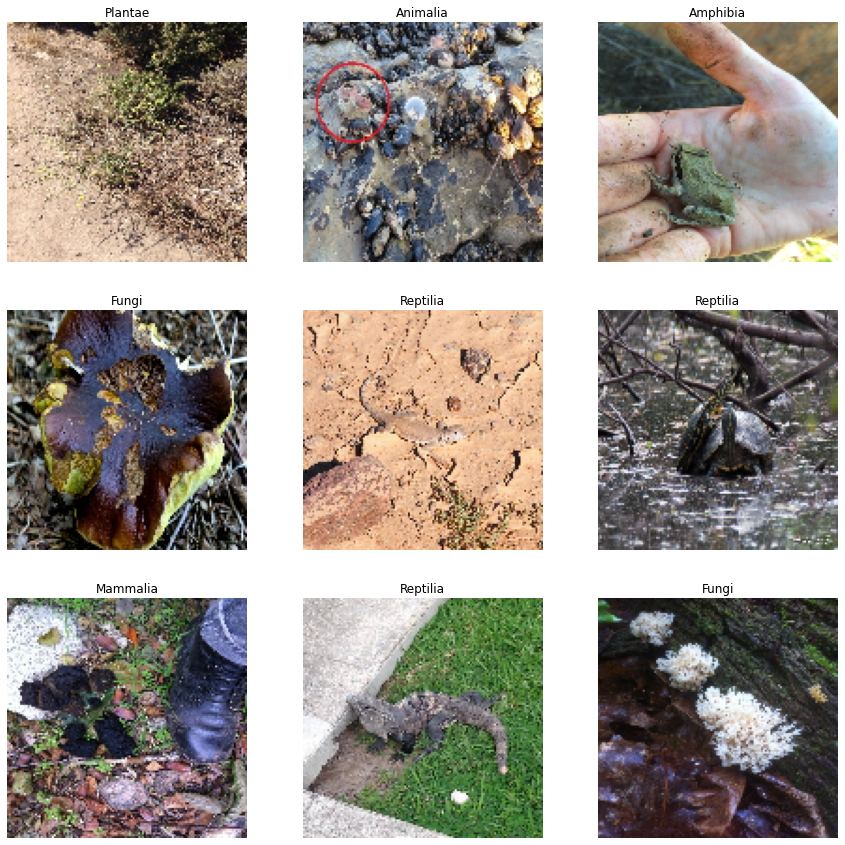

In [4]:
plt.figure(figsize=(15, 15))
images, labels = train_ds.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.where(labels[i] == 1)[0][0]])
    plt.axis("off")

In [5]:
n_filters = config['n_filters']
kernel_size = config['kernel_size']
act_fun = config['activation']
filter_org = config['filter_org']
dropout = config['dropout']
batch_norm = config['batch_norm']

# Creating the model - 

In [6]:
def create_model(n_filters, kernel_size, act_fun, dropout, filter_org, batch_norm):

    model = models.Sequential()
    model.add(layers.Conv2D(n_filters, kernel_size, input_shape=input_size))

    if act_fun == "relu":
        model.add(layers.ReLU())
    elif act_fun == "leaky_relu":
        model.add(layers.LeakyReLU(alpha=0.1))

    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    for i in range(4):
        model.add(layers.Dropout(dropout))
        model.add(layers.Conv2D((filter_org**(i+1))*n_filters, kernel_size))
        if act_fun == "relu":
            model.add(layers.ReLU())
        elif act_fun == "leaky_relu":
            model.add(layers.LeakyReLU(alpha=0.1))

        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    n_dense = 128

    model.add(layers.Flatten())

    if act_fun == "relu":
        model.add(layers.Dense(n_dense, layers.ReLU()))
    elif act_fun == "leaky_relu":
        model.add(layers.Dense(n_dense, layers.LeakyReLU(alpha=0.1)))

    if batch_norm:
        model.add(layers.BatchNormalization())

    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, tf.nn.softmax))

    model.summary()

    return model

model = create_model(n_filters, kernel_size, act_fun, dropout, filter_org, batch_norm)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 61, 61, 128)       0

# Training the model - 

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Evaluating the model on the Test Dataset - 

In [8]:
test_gen = ImageDataGenerator(rescale=1./255)

test_ds = test_gen.flow_from_directory(
    directory='nature_12K/inaturalist_12K/val/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True,
    seed=71)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

Found 2000 images belonging to 10 classes.
2000/2000 - 12s - loss: 2.0518 - accuracy: 0.3845


In [ ]:
model.save('best_model')

In [7]:
model = tf.keras.models.load_model('best_model')

In [ ]:
model.summary()

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(i, layer.name, filters.shape, layer.input.shape, layer.output.shape)

# Sample Images and Predictions from the Test Dataset -

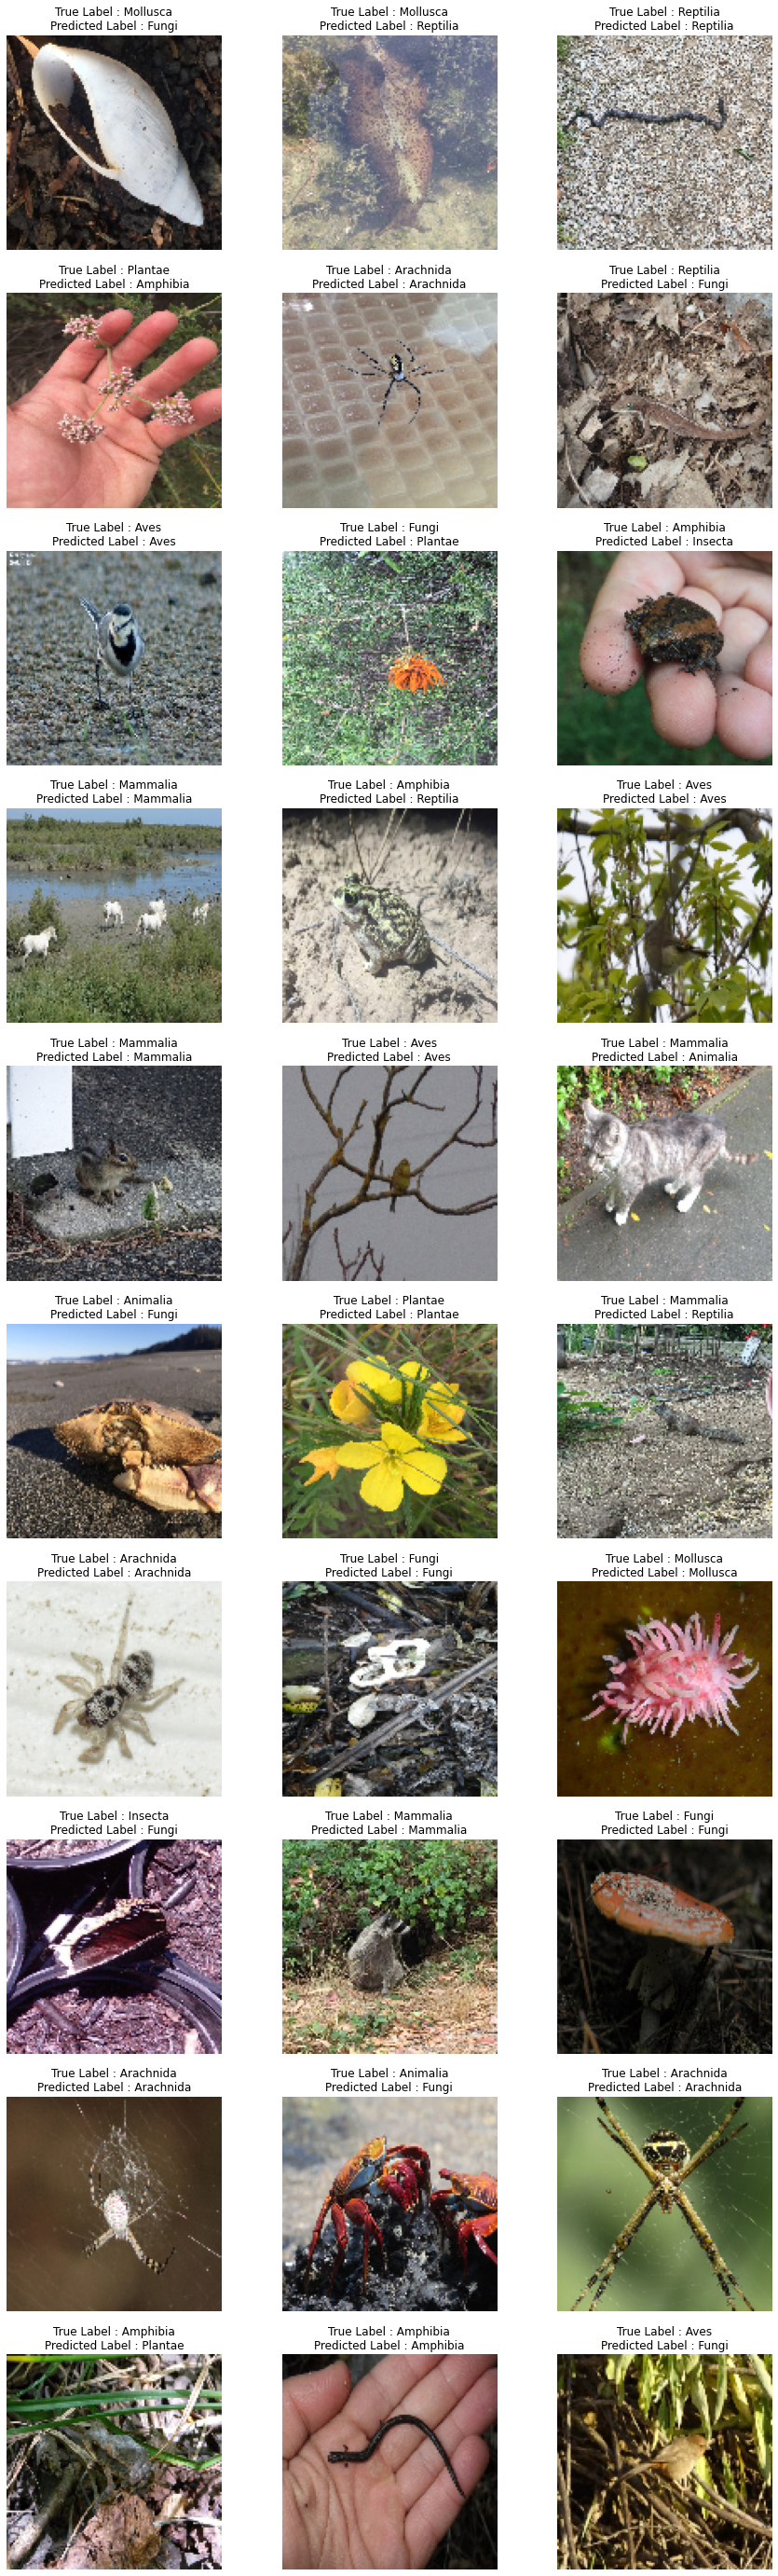

In [9]:
plt.figure(figsize=(15, 50))
for i in range(30):
    ax = plt.subplot(10, 3, i + 1)
    image, label = test_ds.next()
    plt.imshow(image[0])
    y_hat = model.predict(image)
    plt.title(str("True Label : ") + class_names[np.where(label[0,:] == 1)[0][0]] + 
              "\n" + str("Predicted Label : ") + class_names[np.where(y_hat == np.amax(y_hat))[1][0]])
    plt.axis("off")

# Filter Visualisation for an image from the Test Dataset - 

In [19]:
from tensorflow.keras.models import Model

partial_model = Model(inputs=model.inputs, outputs=model.layers[0].output)

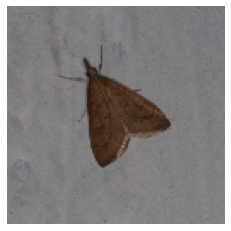

In [22]:
image, label = test_ds.next()

plt.imshow(image[0])
plt.axis("off")
plt.show()

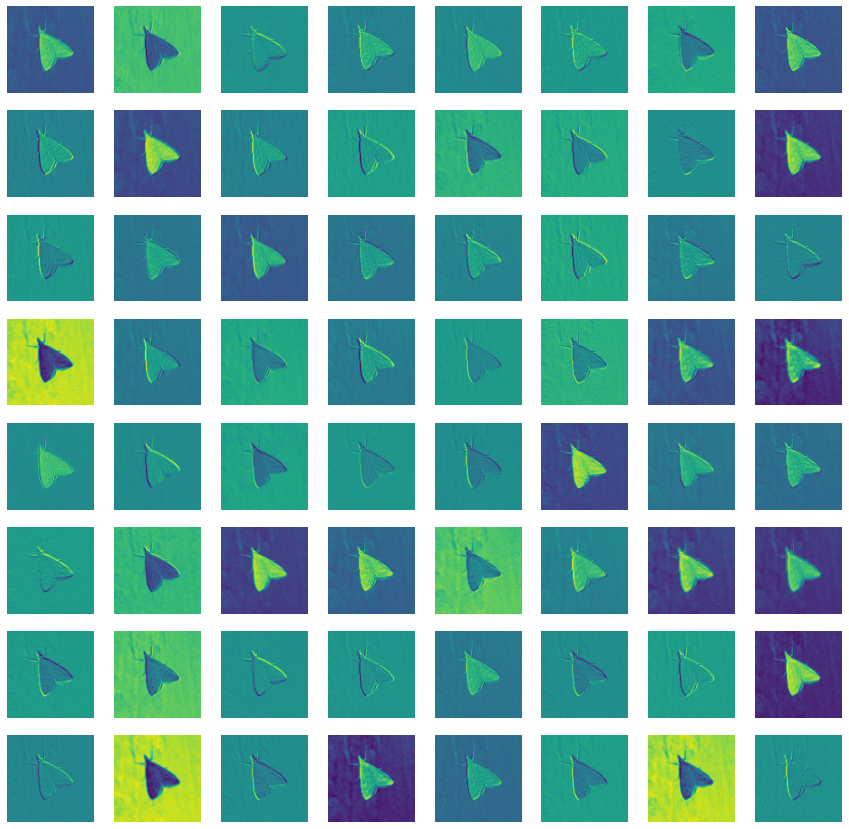

In [23]:
feature_maps = partial_model.predict(image)

plt.figure(figsize=(15, 15))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(feature_maps[0,:,:,i])
    plt.axis("off")

# Guided Backpropagation - 

In [24]:
from tensorflow.keras.models import Model

guided_model = Model(inputs=model.inputs, outputs=model.layers[20].output)

In [25]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

In [27]:
layer_dict = [layer for layer in guided_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    layer.activation = guidedRelu

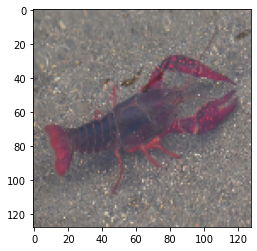

In [28]:
image, label = test_ds.next()
plt.imshow(image[0])

In [29]:
with tf.GradientTape() as tape:
    inputs = tf.cast(image, tf.float32)
    tape.watch(inputs)
    outputs = guided_model(inputs)
    
grads = tape.gradient(outputs,inputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


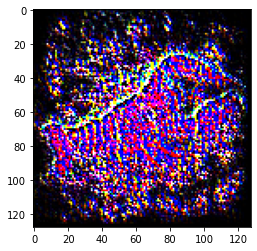

In [30]:
plt.imshow(grads[0])

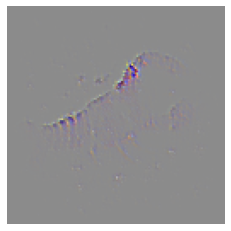

In [31]:
#Visualizing the guided back prop
guided_back_prop = grads[0]
gb_viz = np.dstack((
            guided_back_prop[:, :, 0],
            guided_back_prop[:, :, 1],
            guided_back_prop[:, :, 2],
        ))       
gb_viz -= np.min(gb_viz)
gb_viz /= gb_viz.max()
    
imgplot = plt.imshow(gb_viz)
plt.axis("off")
plt.show()

In [33]:
x_list = []
y_list = []
z_list = []
grads = []
while len(grads)!= 10:
    
    x = np.random.randint(4)
    y = np.random.randint(4)
    z = np.random.randint(1024)
    
    single_neuron_model = Model(inputs=model.inputs, outputs=model.layers[20].output[:,x,y,z])
    
    layer_dict = [layer for layer in single_neuron_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        layer.activation = guidedRelu
    
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        outputs = single_neuron_model(inputs)
        
    if outputs.numpy()[0] != 0:
        grads.append(tape.gradient(outputs,inputs))
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

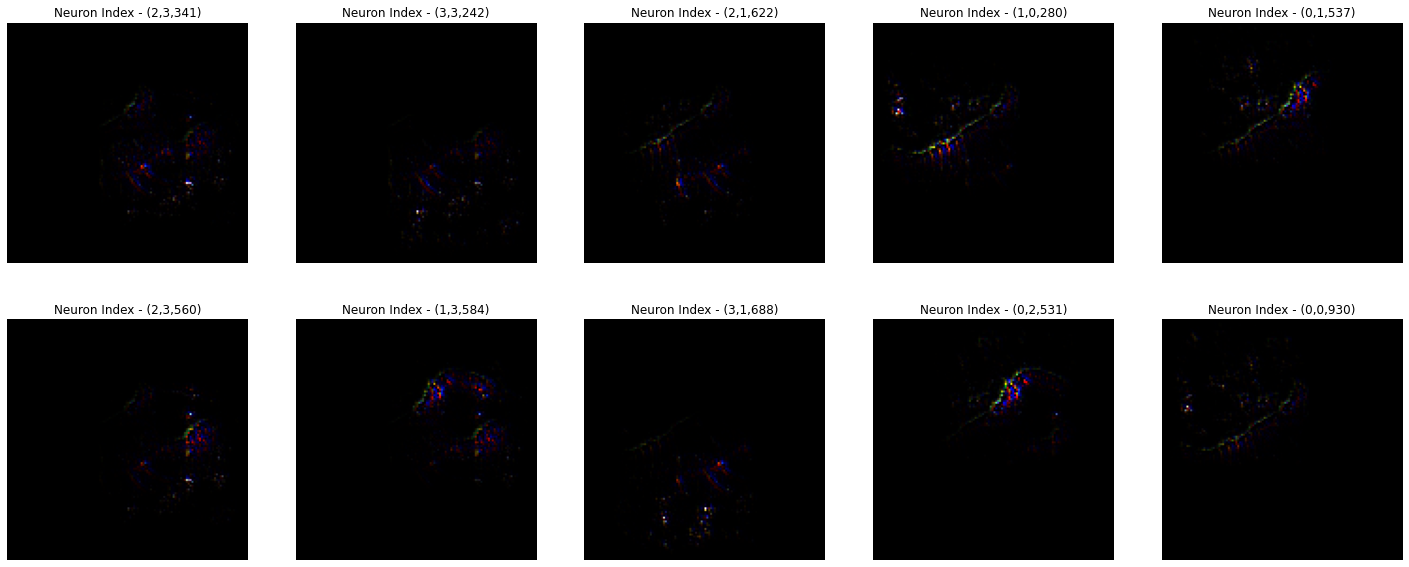

In [34]:
plt.figure(figsize=(25, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(grads[i][0])
    plt.title("Neuron Index - (" + str(x_list[i]) + "," + str(y_list[i]) + "," + str(z_list[i]) + ")")
    plt.axis("off")

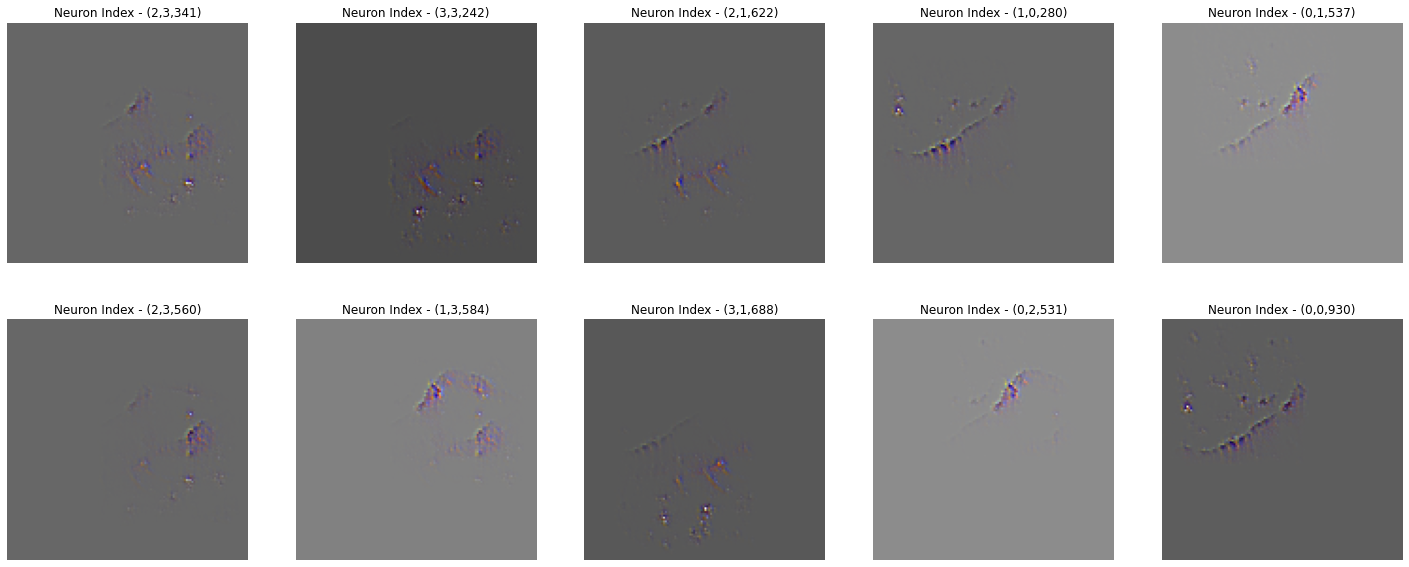

In [35]:
plt.figure(figsize=(25, 10))
for i in range(10):
    guided_back_prop = grads[i][0]
    gb_viz = np.dstack((
                guided_back_prop[:, :, 0],
                guided_back_prop[:, :, 1],
                guided_back_prop[:, :, 2],
            ))       
    gb_viz -= np.min(gb_viz)
    gb_viz /= gb_viz.max()
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(gb_viz)
    plt.title("Neuron Index - (" + str(x_list[i]) + "," + str(y_list[i]) + "," + str(z_list[i]) + ")")
    plt.axis("off")